In [1]:
import torch
torch.manual_seed(1)
from model import *
from loading_data_tensor import *
from testing import *
from visualize import *
import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# import argparse

In [2]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--dataset', type=str, default='FD001', help='which dataset to run')
# opt = parser.parse_args()

In [32]:
num_epochs = 4 # Number of training epochs
d_model = 128  # dimension in encoder
heads = 4  # number of heads in multi-head attention
N = 2  # number of encoder layers
m = 14  # number of features

In [33]:
group, y_test, group_test = loading_FD001()
dropout = 0.1

In [34]:
group.get_group(1).to_numpy().shape

(192, 17)

In [35]:
group.get_group(2).to_numpy().shape

(287, 17)

In [36]:
x = group.get_group(1).to_numpy()
total_loss = 0
model = Transformer(m, d_model, N, heads, dropout)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

In [37]:
for t in range(x.shape[0] - 1):
    if t == 0:  # skip the first and last for convolution without padding
        continue
    else:
        X = x[t - 1:t + 2, 2:-1]  # fetch the 3 * 14 feature as input

    y = x[t, -1:]  # fetch the corresponding target rul as label

    X_train_tensors = Variable(torch.Tensor(X))
    y_train_tensors = Variable(torch.Tensor(y))
    
    X_train_tensors_final = X_train_tensors.reshape(
        (1, 1, X_train_tensors.shape[0], X_train_tensors.shape[1]))


    # forward pass
    outputs = model.forward(X_train_tensors_final, t)


    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    # summarize the loss
    total_loss += loss.item()

    loss = loss / (x.shape[0] - 2)  # normalize the loss
    loss.backward()  # backward pass

    # only update after finishing one unit
    if t == x.shape[0] - 2:  # Wait for several backward steps
        optim.step()  # Now we can do an optimizer step
        optim.zero_grad()  # Reset gradients tensors

# i += 1
# epoch_loss += total_loss / x.shape[0]

In [38]:
for epoch in range(num_epochs):  # iteration of epoch
    i = 1
    epoch_loss = 0

    # training step
    model.train()

    while i <= 100:  # iteration of unit

        # fetch the data of unit i
        x = group.get_group(i).to_numpy()
        total_loss = 0
        optim.zero_grad()

        for t in range(x.shape[0] - 1):
            if t == 0:  # skip the first and last for convolution without padding
                continue
            else:
                X = x[t - 1:t + 2, 2:-1]  # fetch the 3 * 14 feature as input

            y = x[t, -1:]  # fetch the corresponding target rul as label

            X_train_tensors = Variable(torch.Tensor(X))
            y_train_tensors = Variable(torch.Tensor(y))
            
            X_train_tensors_final = X_train_tensors.reshape(
                (1, 1, X_train_tensors.shape[0], X_train_tensors.shape[1]))


            # forward pass
            outputs = model.forward(X_train_tensors_final, t)


            # obtain the loss function
            loss = criterion(outputs, y_train_tensors)

            # summarize the loss
            total_loss += loss.item()

            loss = loss / (x.shape[0] - 2)  # normalize the loss
            loss.backward()  # backward pass

            # only update after finishing one unit
            if t == x.shape[0] - 2:  # Wait for several backward steps
                optim.step()  # Now we can do an optimizer step
                optim.zero_grad()  # Reset gradients tensors

        i += 1
        epoch_loss += total_loss / x.shape[0]

    # evaluate model
    model.eval()

    with torch.no_grad():
        rmse, result = testing(group_test, y_test, model)

    print("Epoch: %d, training loss: %1.5f, testing rmse: %1.5f" % (epoch, epoch_loss / 100, rmse[0]))

Epoch: 0, training loss: 5769.57684, testing rmse: 61.37100
Epoch: 1, training loss: 3637.01015, testing rmse: 47.62993
Epoch: 2, training loss: 2130.94559, testing rmse: 33.03819
Epoch: 3, training loss: 980.00578, testing rmse: 39.78458


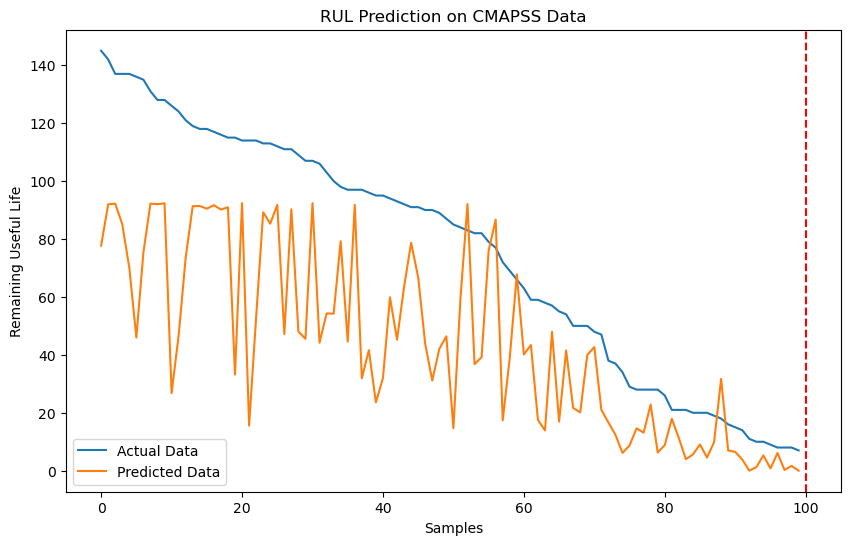

In [39]:
visualize(result, rmse)